In [1]:
import sys
from pathlib import Path

sys.path.append(str(Path().absolute().parent))


In [2]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import (
    ModelCheckpoint,
    EarlyStopping,
    LearningRateMonitor,
)
from torch.nn import MSELoss
from torch.optim import Adam
import matplotlib.pyplot as plt
import numpy as np

import seaborn as sns

import pandas as pd
from pathlib import Path


from src.data_models.caravanify import Caravanify, CaravanifyConfig

from src.data_models.datamodule import HydroDataModule

from sklearn.pipeline import Pipeline

from src.preprocessing.grouped import GroupedTransformer
# from src.preprocessing.log_scale import LogTransformer
from src.preprocessing.standard_scale import StandardScaleTransformer

---

## Testing Caravanify

In [3]:
config = CaravanifyConfig(
    attributes_dir="/Users/cooper/Desktop/CAMELS-CH/data/CARAVANIFY/CH/post_processed/attributes",
    timeseries_dir="/Users/cooper/Desktop/CAMELS-CH/data/CARAVANIFY/CH/post_processed/timeseries/csv",
    gauge_id_prefix="CH",
    use_hydroatlas_attributes=True,
    use_caravan_attributes=True,
    use_other_attributes=True,
)


caravan = Caravanify(config)
ids_for_training = caravan.get_all_gauge_ids()[4:6]

print(f"Total number of stations: {len(ids_for_training)}")



Total number of stations: 2


In [4]:
caravan.load_stations(ids_for_training)


# Get data
ts_data = caravan.get_time_series()
# ts_data = ts_data[ts_data["date"].dt.year >= 1981]
static_data = caravan.get_static_attributes()

In [5]:
ts_data.head()

,gauge_id,date,snow_depth_water_equivalent_mean,surface_net_solar_radiation_mean,surface_net_thermal_radiation_mean,surface_pressure_mean,temperature_2m_mean,dewpoint_temperature_2m_mean,u_component_of_wind_10m_mean,v_component_of_wind_10m_mean,...,u_component_of_wind_10m_max,v_component_of_wind_10m_max,volumetric_soil_water_layer_1_max,volumetric_soil_water_layer_2_max,volumetric_soil_water_layer_3_max,volumetric_soil_water_layer_4_max,total_precipitation_sum,potential_evaporation_sum_ERA5_LAND,potential_evaporation_sum_FAO_PENMAN_MONTEITH,streamflow
0,CH_2019,1981-01-02,2567.62,10.34,1.91,80.38,-10.41,-12.32,0.92,-0.12,...,1.31,0.46,0.39,0.39,0.38,0.42,10.43,0.15,0.16,1.45
1,CH_2019,1981-01-03,2575.40,14.28,-3.30,79.77,-5.85,-8.21,1.04,0.17,...,1.18,0.43,0.39,0.39,0.38,0.42,15.85,0.34,0.22,1.20
2,CH_2019,1981-01-04,2606.18,4.82,-2.55,78.91,-6.16,-7.02,0.93,-0.52,...,1.32,0.45,0.39,0.39,0.38,0.42,46.25,0.00,0.06,1.72
3,CH_2019,1981-01-05,2626.09,12.77,-20.52,79.47,-12.37,-13.91,1.20,-1.22,...,1.50,-0.68,0.39,0.38,0.38,0.42,14.21,0.10,0.01,2.13
4,CH_2019,1981-01-06,2638.53,6.17,-8.17,79.35,-12.79,-14.51,0.99,-0.59,...,1.40,0.49,0.39,0.38,0.38,0.42,25.64,0.06,0.04,2.02


In [6]:
ts_data["date"] = pd.to_datetime(ts_data["date"])

# Now we can get the day of year using dt accessor
ts_data["julian_day"] = ts_data["date"].dt.dayofyear

# Get column names excluding specific columns
ts_columns = [
    "potential_evaporation_sum_ERA5_LAND",
    "potential_evaporation_sum_FAO_PENMAN_MONTEITH",
    "streamflow",
    # "julian_day",
    "temperature_2m_mean",
    "total_precipitation_sum",
]

# Filter date from 1981 onwards

In [7]:
ts_data

,gauge_id,date,snow_depth_water_equivalent_mean,surface_net_solar_radiation_mean,surface_net_thermal_radiation_mean,surface_pressure_mean,temperature_2m_mean,dewpoint_temperature_2m_mean,u_component_of_wind_10m_mean,v_component_of_wind_10m_mean,...,v_component_of_wind_10m_max,volumetric_soil_water_layer_1_max,volumetric_soil_water_layer_2_max,volumetric_soil_water_layer_3_max,volumetric_soil_water_layer_4_max,total_precipitation_sum,potential_evaporation_sum_ERA5_LAND,potential_evaporation_sum_FAO_PENMAN_MONTEITH,streamflow,julian_day
0,CH_2019,1981-01-02,2567.62,10.34,1.91,80.38,-10.41,-12.32,0.92,-0.12,...,0.46,0.39,0.39,0.38,0.42,10.43,0.15,0.16,1.45,2
1,CH_2019,1981-01-03,2575.40,14.28,-3.30,79.77,-5.85,-8.21,1.04,0.17,...,0.43,0.39,0.39,0.38,0.42,15.85,0.34,0.22,1.20,3
2,CH_2019,1981-01-04,2606.18,4.82,-2.55,78.91,-6.16,-7.02,0.93,-0.52,...,0.45,0.39,0.39,0.38,0.42,46.25,0.00,0.06,1.72,4
3,CH_2019,1981-01-05,2626.09,12.77,-20.52,79.47,-12.37,-13.91,1.20,-1.22,...,-0.68,0.39,0.38,0.38,0.42,14.21,0.10,0.01,2.13,5
4,CH_2019,1981-01-06,2638.53,6.17,-8.17,79.35,-12.79,-14.51,0.99,-0.59,...,0.49,0.39,0.38,0.38,0.42,25.64,0.06,0.04,2.02,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29213,CH_2020,2020-12-27,166.04,28.48,-38.38,85.78,-7.03,-13.06,0.05,-0.35,...,0.42,0.24,0.24,0.21,0.29,0.57,1.16,0.00,1.66,362
29214,CH_2020,2020-12-28,176.71,11.25,-11.34,83.98,-5.84,-7.77,0.16,-0.28,...,0.08,0.24,0.24,0.21,0.29,14.58,0.29,0.03,2.30,363
29215,CH_2020,2020-12-29,181.51,19.69,-15.38,84.68,-4.15,-6.49,0.06,-0.10,...,0.32,0.24,0.24,0.21,0.29,0.77,0.61,0.07,2.66,364
29216,CH_2020,2020-12-30,182.06,25.61,-41.17,85.39,-4.16,-7.70,0.07,-0.73,...,-0.27,0.24,0.24,0.21,0.29,0.12,0.56,0.00,2.59,365


In [8]:
whole_data = ts_columns + ["gauge_id", "date"]
ts_data = ts_data[whole_data]

# # Group by gauge_id
# grouped = ts_data.groupby("gauge_id")

# # Plot time series for each gauge of the ts_columns of the last 5 years
# for gauge_id, group in grouped:
#     group = group.set_index("date")
#     group = group.loc["2015-01-01":"2020-12-31"]
#     group[ts_columns].plot(subplots=True, figsize=(20, 20), title=gauge_id)
#     plt.show()

In [9]:
statics_to_keep = [
    "gauge_id",
    "p_mean",
    "area",
    "ele_mt_sav",
    "high_prec_dur",
    "frac_snow",
    "high_prec_freq",
    "slp_dg_sav",
    "cly_pc_sav",
    "aridity_ERA5_LAND",
    "aridity_FAO_PM",
]

static_columns = static_data.columns
static_columns = [col for col in list(static_columns) if col in statics_to_keep]

static_data = static_data[static_columns]
static_data

,gauge_id,area,cly_pc_sav,ele_mt_sav,slp_dg_sav,aridity_ERA5_LAND,aridity_FAO_PM,frac_snow,high_prec_dur,high_prec_freq,p_mean
0,CH_2019,554.489324,12.929081,2130.274450,272.113992,0.462579,0.157501,0.420558,1.206490,0.027996,5.468537
1,CH_2020,203.514362,13.882564,1240.535351,288.983838,1.333966,0.334716,0.150551,1.373796,0.048806,4.342311


In [10]:
features = [
    col for col in ts_data.columns if col not in ["gauge_id", "date", "streamflow"]
]
ts_columns = features + ["streamflow"]  # Ensure target is not in features

# 1. Load and prepare CAMELS-CH data

In [11]:
# camels_config = CamelsCHConfig(
#     timeseries_dir="/Users/cooper/Desktop/CAMELS-CH/data/timeseries/observation_based/",
#     timeseries_pattern="CAMELS_CH_obs_based_*.csv",
#     static_attributes_dir="/Users/cooper/Desktop/CAMELS-CH/data/static_attributes",
#     use_climate=False,
#     use_geology=False,
#     use_glacier=False,
#     use_human_influence=False,
#     use_hydrogeology=False,
#     use_hydrology=False,
#     use_landcover=False,
#     use_soil=False,
#     use_topographic=False,
# )

In [12]:
# all_gauge_ids = get_all_gauge_ids(camels_config)

# ids_for_training = all_gauge_ids[:5]

# camels = CamelsCH(camels_config)
# camels.load_stations(ids_for_training)

In [13]:
# data = camels.get_time_series()
# data = data[
#     [
#         "gauge_id",
#         "date",
#         "discharge_spec(mm/d)",
#     ]
# ]

# data

In [14]:
# static = camels.get_static_attributes()
# sc = static.columns

# # for i in range(len(sc)):
# #     print(f"{i}: {sc[i]}")
# static_attributes = [
#     "gauge_id",
#     "area",
#     "elev_mean",
#     "slope_mean",
#     "aridity",
#     "p_seasonality",
#     "frac_snow",
#     "porosity",
#     "conductivity",
#     "p_mean",
#     "geo_porosity",
# ]
# static = static[static_attributes]
# static

# 2. Configure preprocessing

In [15]:
dynamic_feature_cols = features
static_feature_cols = [c for c in static_columns if c != "gauge_id"]
target_cols = ["streamflow"]

# Feature pipeline: log + scale
feature_pipeline = Pipeline(
    [
        # ("log", LogTransformer(columns=dynamic_feature_cols)),
        ("scaler", StandardScaleTransformer(columns=dynamic_feature_cols))
    ]
)

# Target pipeline: grouped by basin with log + scale
target_pipeline = GroupedTransformer(
    Pipeline(
        [
            # ("log", LogTransformer(columns=target_cols)),
            ("scaler", StandardScaleTransformer(columns=target_cols))
        ]
    ),
    columns=target_cols,
    group_identifier="gauge_id",
    n_jobs=-1,
)

# Static feature pipeline: just scaling
static_pipeline = Pipeline(
    [("scaler", StandardScaleTransformer(columns=static_feature_cols))]
)

# Define preprocessing configurations
preprocessing_configs = {
    "features": {"pipeline": feature_pipeline, "columns": dynamic_feature_cols},
    "target": {"pipeline": target_pipeline, "columns": target_cols},
    "static_features": {"pipeline": static_pipeline, "columns": static_feature_cols},
}

In [16]:
static_columns

['gauge_id',
 'area',
 'cly_pc_sav',
 'ele_mt_sav',
 'slp_dg_sav',
 'aridity_ERA5_LAND',
 'aridity_FAO_PM',
 'frac_snow',
 'high_prec_dur',
 'high_prec_freq',
 'p_mean']

# 3. Create DataModule

In [ ]:
output_length = 10
input_length = 40

static_columns = [c for c in static_columns if c not in ["gauge_id"]]

print("TS columns:", ts_columns)
print("Static columns:", static_columns)


data_module = HydroDataModule(
    time_series_df=ts_data,
    static_df=static_data,
    # static_df=None,
    group_identifier="gauge_id",
    preprocessing_config=preprocessing_configs,
    batch_size=128,
    input_length=input_length,
    output_length=output_length,
    num_workers=4,
    features=ts_columns,
    static_features=static_columns,
    # static_features=None,
    target="streamflow",
    min_train_years=2,
    val_years=1,
    test_years=1,
    max_missing_pct=20,
    domain_id="CH",
)

data_module.prepare_data()
data_module.setup()
# train_loader = data_module.test_dataloader()

# for i, batch in enumerate(train_loader):
#     if i >= 6:  # Look at first 6 batches
#         break

#     print(f"Slice indeces: {batch['slice_idx']}")

TS columns: ['potential_evaporation_sum_ERA5_LAND', 'potential_evaporation_sum_FAO_PENMAN_MONTEITH', 'temperature_2m_mean', 'total_precipitation_sum', 'streamflow']
Static columns: ['area', 'cly_pc_sav', 'ele_mt_sav', 'slp_dg_sav', 'aridity_ERA5_LAND', 'aridity_FAO_PM', 'frac_snow', 'high_prec_dur', 'high_prec_freq', 'p_mean']
Original basins: 2
Retained basins: 2
Domain CL (source): Created 27658 valid sequences from 2 catchments
Domain CL (source): Created 632 valid sequences from 2 catchments
Domain CL (source): Created 634 valid sequences from 2 catchments


In [18]:
static_columns

['area',
 'cly_pc_sav',
 'ele_mt_sav',
 'slp_dg_sav',
 'aridity_ERA5_LAND',
 'aridity_FAO_PM',
 'frac_snow',
 'high_prec_dur',
 'high_prec_freq',
 'p_mean']

In [19]:
data_module.target

'streamflow'

## 4. Create model and train

In [20]:

from src.models.TSMixer import LitTSMixer, TSMixerConfig
from src.models.evaluators import TSForecastEvaluator


# 5. Evalue and plot results

In [21]:
config = TSMixerConfig(
    input_len=input_length,
    output_len=output_length,
    input_size=len(ts_columns),
    static_size=len(static_columns),
    hidden_size=30,
    learning_rate=7e-4,
    dropout=0.1,
    num_layers=2,
)

model = LitTSMixer(config)

# Configure trainer
trainer = pl.Trainer(
    max_epochs=4,
    accelerator="cpu",
    devices=1,
    callbacks=[
        ModelCheckpoint(
            monitor="val_loss",
            dirpath="checkpoints",
            filename="best-checkpoint",
            save_top_k=1,
            mode="min",
        ),
        EarlyStopping(monitor="val_loss", patience=3, mode="min"),
        LearningRateMonitor(logging_interval="epoch"),
    ],
)

# Train the model
trainer.fit(model, data_module)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/cooper/Desktop/CAMELS-CH/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.


Original basins: 2
Retained basins: 2


/Users/cooper/Desktop/CAMELS-CH/.venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /Users/cooper/Desktop/CAMELS-CH/notebooks/checkpoints exists and is not empty.

  | Name          | Type    | Params | Mode 
--------------------------------------------------
0 | model         | TSMixer | 12.6 K | train
1 | mse_criterion | MSELoss | 0      | train
--------------------------------------------------
12.6 K    Trainable params
0         Non-trainable params
12.6 K    Total params
0.051     Total estimated model params size (MB)
49        Modules in train mode
0         Modules in eval mode


Domain CL (source): Created 27658 valid sequences from 2 catchments
Domain CL (source): Created 632 valid sequences from 2 catchments


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=4` reached.


In [22]:
quality_report = data_module.quality_report

excluded_basins = list(quality_report["excluded_basins"].keys())
excluded_basins

ids_for_training = [id for id in ids_for_training if id not in excluded_basins]

In [23]:
# quality_report

In [24]:
trainer.test(model, data_module)
raw_results = model.test_results

# Create evaluator and get metrics
evaluator = TSForecastEvaluator(
    data_module, horizons=list(range(1, model.config.output_len + 1))
)
results_df, overall_metrics, basin_metrics = evaluator.evaluate(raw_results)

# Get overall summary
overall_summary = evaluator.summarize_metrics(overall_metrics)

# Get per-basin summary
basin_summary = evaluator.summarize_metrics(basin_metrics, per_basin=True)

Original basins: 2
Retained basins: 2
Domain CL (source): Created 634 valid sequences from 2 catchments


Testing: |          | 0/? [00:00<?, ?it/s]

In [25]:
# raw_results

Found 317 matches for CH_2020
Extracted 317 predictions and 317 observations
Predictions range: [-0.9168696999549866, 2.9072937965393066]
Observations range: [-0.7806849479675293, 13.686042785644531]
After inverse transform:
Predictions range: [0.5518589019775391, 13.697586059570312]
Observations range: [1.0199999809265137, 50.75]
Found 366 rows for basin CH_2020 in dataset
Extracted 317 test dates
First date: 2020-02-19T00:00:00.000000000, Last date: 2020-12-31T00:00:00.000000000


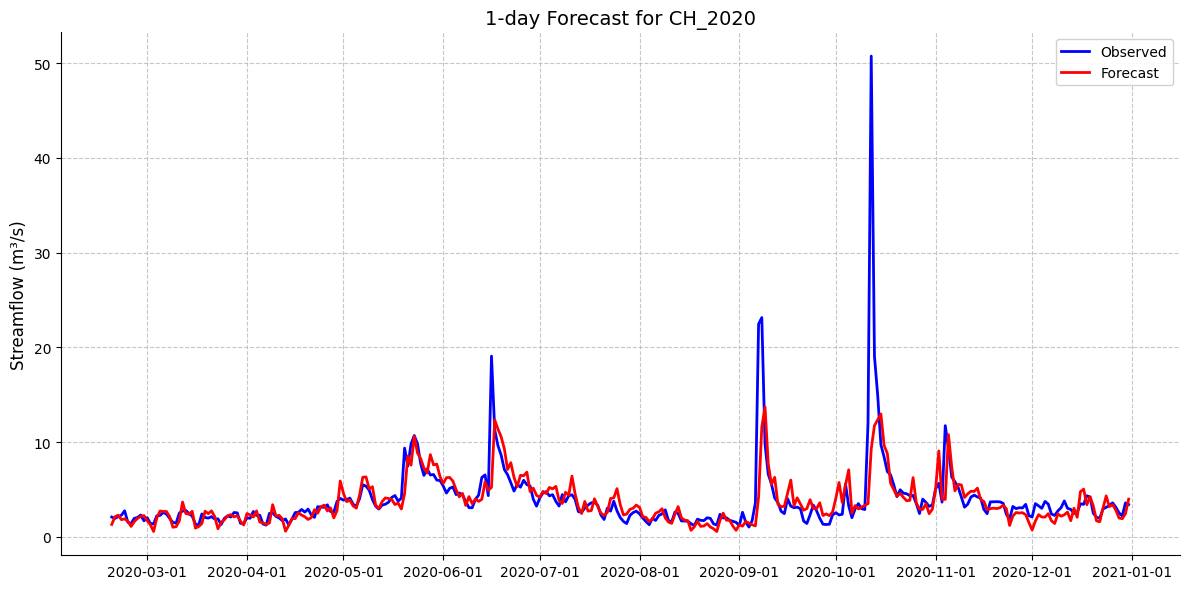

In [28]:
evaluator.test_results = raw_results

# Assuming you have an evaluator with test results already populated
fig, ax = evaluator.plot_rolling_forecast(
    horizon=1,
    group_identifier="CH_2020",
    datamodule=data_module,
    y_label="Streamflow (m³/s)",
    debug=True,
    line_style_forecast="-",
)

plt.show()

In [29]:
overall_summary

,MSE,MAE,NSE,RMSE
horizon,,,,
1,6.220294,1.086531,0.529471,2.494052
2,8.522086,1.262881,0.355058,2.919261
3,8.906748,1.339530,0.325763,2.984417
4,9.365584,1.442839,0.291170,3.060324
5,9.832216,1.487653,0.256447,3.135637
6,9.813771,1.501839,0.259002,3.132694
7,9.966659,1.504569,0.247079,3.157001
8,9.909990,1.518464,0.250964,3.148014
9,9.824986,1.525130,0.257330,3.134483


In [30]:
basin_summary

MSE       MAE       NSE      RMSE
basin_id horizon                                         
CH_2019  1         3.367684  1.114182  0.654580  1.835125
         2         4.278594  1.247799  0.561247  2.068476
         3         4.263545  1.252581  0.562609  2.064835
         4         4.435021  1.312439  0.545168  2.105949
         5         4.557856  1.322532  0.533336  2.134914
         6         4.485631  1.288705  0.542720  2.117931
         7         4.747023  1.326281  0.516114  2.178766
         8         4.865860  1.331335  0.504529  2.205869
         9         4.868270  1.344315  0.504867  2.206416
         10        4.908250  1.380694  0.501382  2.215457
CH_2020  1         9.072903  1.058880  0.392146  3.012126
         2        12.765578  1.277963  0.144295  3.572895
         3        13.549951  1.426480  0.091544  3.681026
         4        14.296149  1.573240  0.041640  3.781025
         5        15.106575  1.652773 -0.012259  3.886718
         6        15.141914  1.714973 -0.013864  3.891261
         7        15.186296  1.682858 -0.017476  3.896960
         8        14.954120  1.705592 -0.002893  3.867056
         9        14.781701  1.705945  0.008237  3.844698
         10       14.934620  1.811796 -0.002248  3.864534

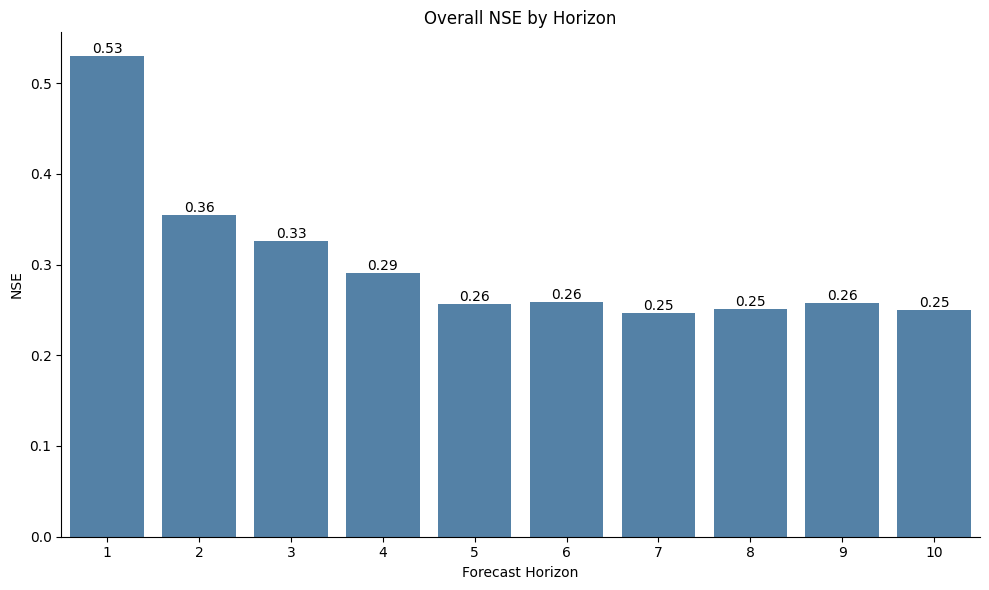

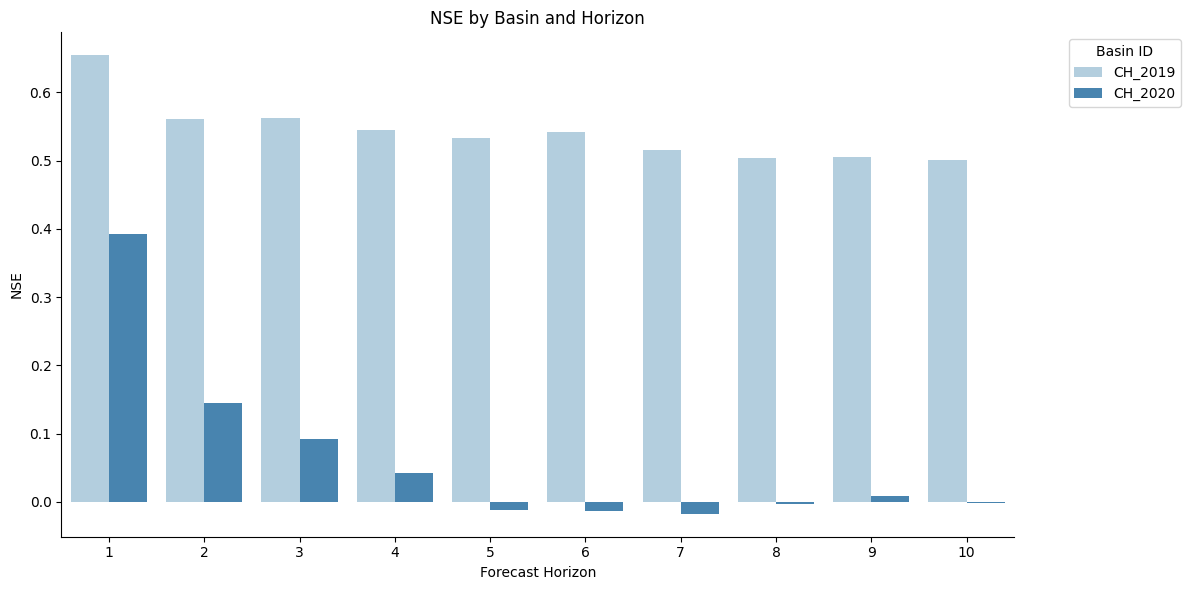

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns


def plot_metric_summary(
    summary_df: pd.DataFrame, metric: str, per_basin: bool = False, figsize=(10, 6)
):
    plt.figure(figsize=figsize)

    if per_basin:
        df_plot = summary_df[metric].unstack(level=0)

        # Sort basins based on first horizon values
        first_horizon_values = df_plot.iloc[0]
        sorted_basins = first_horizon_values.sort_values(ascending=False).index
        df_plot = df_plot[sorted_basins]

        sns.barplot(
            data=df_plot.melt(ignore_index=False).reset_index(),
            x="horizon",
            y="value",
            hue="basin_id",
            palette="Blues",
        )
        plt.title(f"{metric} by Basin and Horizon")
        plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", title="Basin ID")

    else:
        ax = sns.barplot(x=summary_df.index, y=summary_df[metric], color="steelblue")
        plt.title(f"Overall {metric} by Horizon")

        for i, v in enumerate(summary_df[metric]):
            ax.text(i, v, f"{v:.2f}", ha="center", va="bottom")

    plt.xlabel("Forecast Horizon")
    plt.ylabel(metric)
    plt.tight_layout()
    sns.despine()
    plt.show()


# Usage example:
plot_metric_summary(overall_summary, "NSE")  # Plot overall NSE
plot_metric_summary(basin_summary, "NSE", per_basin=True, figsize=(12, 6))